<a href="https://colab.research.google.com/github/drpetros11111/tensorflow-deep-learning/blob/main/01_neural_network_regression_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

In [13]:
import tensorflow as tf
print(tf.__version__) # check the version (should be 2.x+)

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

2.17.0
Notebook last run (end-to-end): 2024-08-15 16:19:27.118937


## Creating data to view and fit

Since we're working on a **regression problem** (predicting a number) let's create some linear data (a straight line) to model.

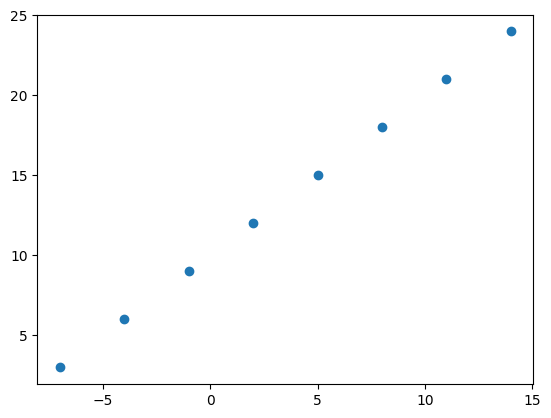

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

Before we do any modelling, can you calculate the pattern between `X` and `y`?

For example, say I asked you, based on this data what the `y` value would be if `X` was 17.0?

Or how about if `X` was -10.0?

This kind of pattern discovery is the essence of what we'll be building neural networks to do for us.

## Regression input shapes and output shapes

One of the most important concepts when working with neural networks are the input and output shapes.

The **input shape** is the shape of your data that goes into the model.

The **output shape** is the shape of your data you want to come out of your model.

These will differ depending on the problem you're working on.

Neural networks accept numbers and output numbers. These numbers are typically represented as tensors (or arrays).

Before, we created data using NumPy arrays, but we could do the same with tensors.

In [15]:
# Example input and output shapes of a regression model
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [16]:
house_info.shape

TensorShape([3])

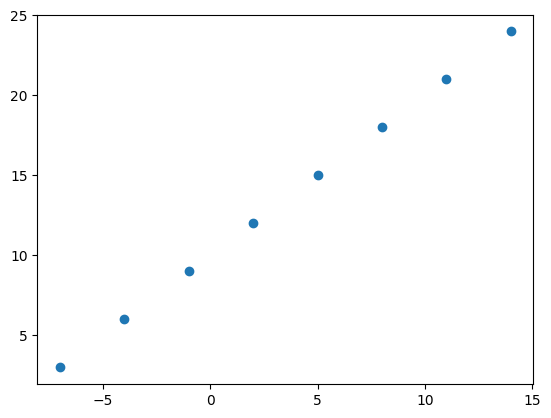

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create features (using tensors)
X = tf.constant([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels (using tensors)
y = tf.constant([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y);

Our goal here will be to use `X` to predict `y`.

So our **input** will be `X` and our **output** will be `y`.

Knowing this, what do you think our input and output shapes will be?

Let's take a look.

In [18]:
# Take a single example of X
input_shape = X[0].shape

# Take a single example of y
output_shape = y[0].shape

input_shape, output_shape # these are both scalars (no shape)

(TensorShape([]), TensorShape([]))

Huh?

From this it seems our inputs and outputs have no shape?

How could that be?

It's because no matter what kind of data we pass to our model, it's always going to take as input and return as output some kind of tensor.

But in our case because of our dataset (only 2 small lists of numbers), we're looking at a special kind of tensor, more specifically a rank 0 tensor or a scalar.

In [19]:
# Let's take a look at the single examples invidually
X[0], y[0]

(<tf.Tensor: shape=(), dtype=float32, numpy=-7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.0>)

In our case, we're trying to build a model to predict the pattern between `X[0]` equalling `-7.0` and `y[0]` equalling `3.0`.

So now we get our answer, we're trying to use 1 `X` value to predict 1 `y` value.

You might be thinking, "this seems pretty complicated for just predicting a straight line...".

And you'd be right.

But the concepts we're covering here, the concepts of input and output shapes to a model are fundamental.

In fact, they're probably two of the things you'll spend the most time on when you work with neural networks: **making sure your input and outputs are in the correct shape**.

If it doesn't make sense now, we'll see plenty more examples later on (soon you'll notice the input and output shapes can be almost anything you can imagine).

![example of input and output shapes for a housing price prediction problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/01-input-and-output-shapes-housing-prices.png)
*If you were working on building a machine learning algorithm for predicting housing prices, your inputs may be number of bedrooms, number of bathrooms and number of garages, giving you an input shape of 3 (3 different features). And since you're trying to predict the price of the house, your output shape would be 1.*

## Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).

Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

> **Note:** If you're using [TensorFlow 2.7.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.7.0)+, the `fit()` function no longer upscales input data to go from `(batch_size, )` to `(batch_size, 1)`. To fix this, you'll need to expand the dimension of input data using `tf.expand_dims(input_data, axis=-1)`.
>
> In our case, this means instead of using `model.fit(X, y, epochs=5)`, use `model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)`.

In [20]:
# Set random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

# Fit the model
# model.fit(X, y, epochs=5) # this will break with TensorFlow 2.7.0+
model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step - loss: 19.2543 - mae: 19.2543
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 18.9731 - mae: 18.9731
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 18.6918 - mae: 18.6918
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18.4106 - mae: 18.4106
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 18.1293 - mae: 18.1293


Boom!

We've just trained a model to figure out the patterns between `X` and `y`.

How do you think it went?

In [21]:
# Check out X and y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

What do you think the outcome should be if we passed our model an `X` value of 17.0?

In [22]:
import numpy as np # Import numpy

# Make a prediction with the model
model.predict(np.array([17.0])) # Convert the list to a NumPy array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[-16.561596]], dtype=float32)

It doesn't go very well... it should've output something close to 27.0.

> 🤔 **Question:** What's Keras? I thought we were working with TensorFlow but every time we write TensorFlow code, `keras` comes after `tf` (e.g. `tf.keras.layers.Dense()`)?

Before TensorFlow 2.0+, [Keras](https://keras.io/) was an API designed to be able to build deep learning models with ease. Since TensorFlow 2.0+, its functionality has been tightly integrated within the TensorFlow library.

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [23]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (this time we'll train for longer)
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100) # train for 100 epochs not 10

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - loss: 11.0965 - mae: 11.0965
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 10.9640 - mae: 10.9640
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 10.8315 - mae: 10.8315
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 10.6990 - mae: 10.6990
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.5665 - mae: 10.5665
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 10.4340 - mae: 10.4340
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.3015 - mae: 10.3015
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 10.1690 - mae: 10.1690
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 10.0365 - mae: 10.0365
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.9040 - mae: 9.9040
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 9.7715 - mae: 9.7715
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 9.6390 - mae: 9.6390
Epoch 13/100
1/1 ━━━━━━━━━━━━━

# Create a Model

    model = tf.keras.Sequential([
     tf.keras.layers.Dense(1)
    ])


---


## Model Architecture

The model consists of a single dense layer with one unit.

##Input and Output:
The dense layer takes a single input feature (since no input_shape is explicitly set, it is inferred during the first batch of training).

The layer outputs a single value, which is a linear combination of the input features and weights plus a bias term.

There’s no activation function applied here, so the output can be any real number (positive or negative).

---------
##Compile the Model:

    model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

------
##Loss Function:
The model uses Mean Absolute Error (MAE) as the loss function. MAE measures the average of the absolute differences between the predicted values and the true values.

It’s suitable for regression tasks where you want to minimize the distance between predicted and actual values.

------
##Optimizer:
Stochastic Gradient Descent (SGD) is used to update the model weights during training.

SGD is a straightforward optimization algorithm that updates weights incrementally for each batch of training data.

-----
##Metrics:
The model is also evaluated using MAE as a metric during training, which helps track how well the model is performing over time.

------
##Fit the Model:

    model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

--------
##Training Data:
X is the input data, which is expanded to have an additional dimension using

    tf.expand_dims(X, axis=-1)

changing its shape from (batch_size,) to (batch_size, 1).

This ensures that each input is treated as having a single feature.

y is the target data, which the model tries to predict.

------
##Epochs:
The model is trained for 100 epochs, meaning it will go through the entire dataset 100 times during training.

More epochs generally allow the model to learn more from the data, potentially improving performance but also increasing the risk of overfitting.

Effect of Training for 100 Epochs
Training for 100 epochs instead of a smaller number like 10 will have several implications:

=====
##Model Learning:

With more epochs, the model has more opportunities to adjust its weights to minimize the loss (MAE).

This usually results in a better fit to the training data, potentially leading to lower loss and improved accuracy on the training data.

----------
##Overfitting Risk:

Overfitting occurs when the model learns the training data too well, including noise and outliers, leading to poor performance on unseen data.

Training for too many epochs increases the risk of overfitting, especially with a simple model and a small dataset.

However, since your model is very simple (just one dense layer with one unit), the risk of overfitting is somewhat lower, though still present.

---------
##Convergence:

If the model converges quickly (i.e., the loss stops decreasing significantly after a certain number of epochs), continuing to train may not provide much additional benefit.

You might see that the loss plateaus after some epochs, indicating that the model has learned as much as it can from the data.

-----
##Impact on Output:

By training longer, the model might better approximate the relationship between X and y, potentially reducing prediction errors.

However, this depends on whether the model is underfitting or overfitting.

------
#Summary
100 Epochs: Training for 100 epochs allows the model more time to learn from the data. This can improve the model’s performance but also increases the risk of overfitting.

Simple Model: Given that your model is very simple, it might benefit from additional epochs without overfitting too quickly.
 Monitoring the loss during training can help you decide if 100 epochs are necessary or if you can stop early.

You might've noticed the loss value decrease from before (and keep decreasing as the number of epochs gets higher).

What do you think this means for when we make a prediction with our model?

How about we try predict on 17.0 again?

In [24]:
# Remind ourselves of what X and y are
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [25]:
import tensorflow as tf  # Import TensorFlow if not already imported

# Try and predict what y would be if X was 17.0
prediction = model.predict(tf.constant([17.0]))  # Convert the list to a TensorFlow tensor
print(prediction)  # the right answer is 27.0 (y = X + 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[29.751793]]


Much better!

We got closer this time. But we could still be better.

Now we've trained a model, how could we evaluate it?

## Evaluating a model

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

### Visualize, visualize, visualize

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize."

This is because you're probably better looking at something (doing) than you are thinking about something.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

But first, we'll create a little bit of a bigger dataset and a new model we can use (it'll be the same as before, but the more practice the better).


In [26]:
# Make a bigger dataset
X = np.arange(-100, 100, 4)
X

array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96])

In [27]:
# Make labels for the dataset (adhering to the same pattern as before)
y = np.arange(-90, 110, 4)
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

Since $y=X+10$, we could make the labels like so:

In [28]:
# Same result as above
y = X + 10
y

array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

## Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you take before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [29]:
# Check how many samples we have
len(X)

50

In [30]:
# Split data into train and test sets
X_train = X[:40] # first 40 examples (80% of data)
y_train = y[:40]

X_test = X[40:] # last 10 examples (20% of data)
y_test = y[40:]

len(X_train), len(X_test)

(40, 10)

## Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.

Let's plot it with some nice colours to differentiate what's what.

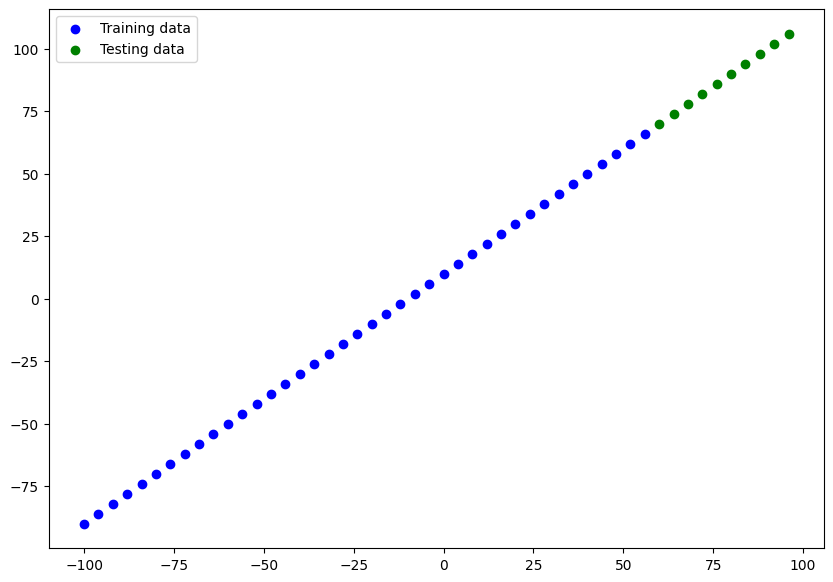

In [31]:
plt.figure(figsize=(10, 7))
# Plot training data in blue
plt.scatter(X_train, y_train, c='b', label='Training data')
# Plot test data in green
plt.scatter(X_test, y_test, c='g', label='Testing data')
# Show the legend
plt.legend();

Beautiful! Any time you can visualize your data, your model, your anything, it's a good idea.

With this graph in mind, what we'll be trying to do is build a model which learns the pattern in the blue dots (`X_train`) to draw the green dots (`X_test`).

Time to build a model. We'll make the exact same one from before (the one we trained for longer).

In [32]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# Fit model (same as above)
#model.fit(X_train, y_train, epochs=100) # commented out on purpose (not fitting it just yet)

## Visualizing the model

After you've built a model, you might want to take a look at it (especially if you haven't built many before).

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

> 🔑 **Note:** Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [33]:
# Doesn't work (model not fit/built)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Ahh, the cell above errors because we haven't fit or built our model.

We also haven't told it what input shape it should be expecting.

Remember above, how we discussed the input shape was just one number?

We can let our model know the input shape of our data using the `input_shape` parameter to the first layer (usually if `input_shape` isn't defined, Keras tries to figure it out automatically).

In [34]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[1]) # define the input_shape to our model
])

# Compile model (same as above)
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# This will work after specifying the input shape
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

> 📖 **Resource:** For a more in-depth overview of the trainable parameters within a layer, check out [MIT's introduction to deep learning video](https://youtu.be/njKP3FqW3Sk).

> 🛠 **Exercise:** Try playing around with the number of hidden units in the `Dense` layer (e.g. `Dense(2)`, `Dense(3)`). How does this change the Total/Trainable params? Investigate what's causing the change.

For now, all you need to think about these parameters is that their learnable patterns in the data.

Let's fit our model to the training data.

In [36]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, verbose=0) # verbose controls how much gets output

In [37]:
# Check the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4 (20.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Alongside summary, you can also view a 2D plot of the model using [`plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

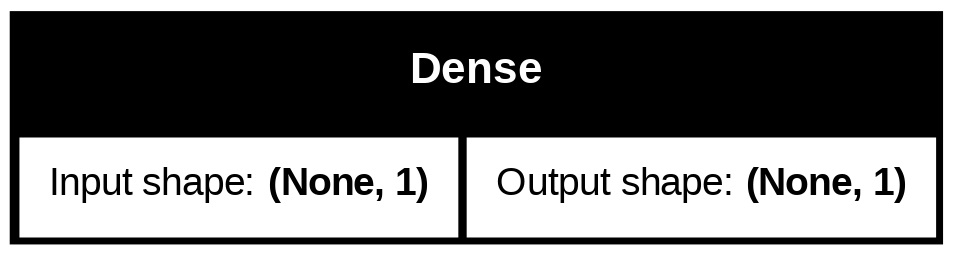

In [38]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In our case, the model we used only has an input and an output but visualizing more complicated models can be very helpful for debugging.

## Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [39]:
# Make predictions
y_preds = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [40]:
# View the predictions
y_preds

array([[57.292595],
       [61.017227],
       [64.74186 ],
       [68.46649 ],
       [72.191124],
       [75.91576 ],
       [79.64038 ],
       [83.36501 ],
       [87.089645],
       [90.81428 ]], dtype=float32)

Okay, we get a list of numbers but how do these compare to the ground truth labels?

Let's build a plotting function to find out.

> 🔑 **Note:** If you think you're going to be visualizing something a lot, it's a good idea to functionize it so you can use it later.

In [41]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=y_preds):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot the predictions in red (predictions were made on the test data)
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

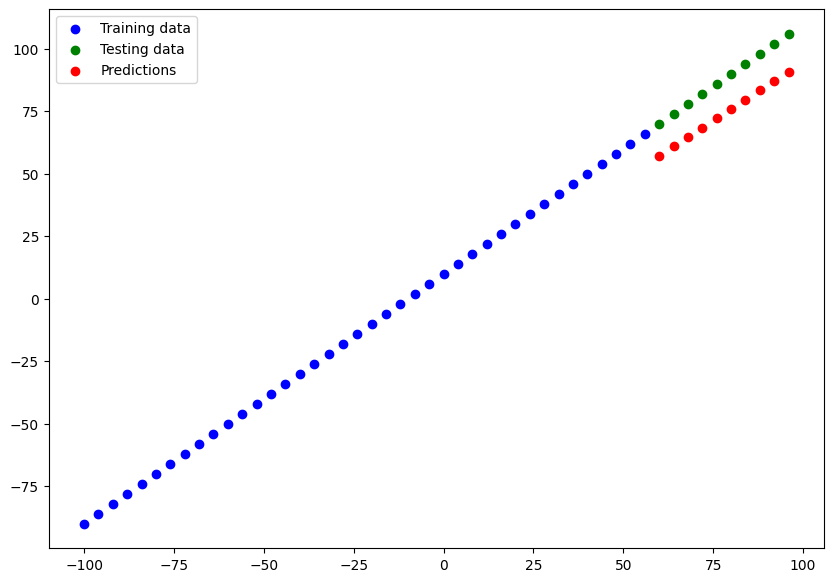

In [42]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

From the plot we can see our predictions aren't totally outlandish but they definitely aren't anything special either.

## Evaluating predictions

Alongisde visualizations, evaulation metrics are your alternative best option for evaluating your model.

Depending on the problem you're working on, different models have different evaluation metrics.

Two of the main metrics used for regression problems are:
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).

The lower each of these values, the better.

You can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) which will return the loss of the model as well as any metrics setup during the compile step.

In [43]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 13.9466 - mae: 13.9466


[13.946563720703125, 13.946563720703125]

In our case, since we used MAE for the loss function as well as MAE for the metrics, `model.evaulate()` returns them both.

TensorFlow also has built in functions for MSE and MAE.

For many evaluation functions, the premise is the same: compare predictions to the ground truth labels.

In [44]:
import tensorflow as tf
# Create a MeanAbsoluteError metric object
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update the metric state with the true and predicted values
mae_metric.update_state(y_true=y_test, y_pred=y_preds)

# Get the result (mean absolute error)
mae = mae_metric.result().numpy()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 13.946563720703125


Huh? That's strange, MAE should be a single output.

Instead, we get 10 values.

This is because our `y_test` and `y_preds` tensors are different shapes.

In [45]:
# Check the test label tensor values
y_test

array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106])

In [46]:
# Check the predictions tensor values (notice the extra square brackets)
y_preds

array([[57.292595],
       [61.017227],
       [64.74186 ],
       [68.46649 ],
       [72.191124],
       [75.91576 ],
       [79.64038 ],
       [83.36501 ],
       [87.089645],
       [90.81428 ]], dtype=float32)

In [47]:
# Check the tensor shapes
y_test.shape, y_preds.shape

((10,), (10, 1))

Remember how we discussed dealing with different input and output shapes is one the most common issues you'll come across, this is one of those times.

But not to worry.

We can fix it using [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze), it'll remove the the `1` dimension from our `y_preds` tensor, making it the same shape as `y_test`.

> 🔑 **Note:** If you're comparing two tensors, it's important to make sure they're the right shape(s) (you won't always have to manipulate the shapes, but always be on the look out, *many* errors are the result of mismatched tensors, especially mismatched input and output shapes).

In [48]:
# Shape before squeeze()
y_preds.shape

(10, 1)

In [49]:
# Shape after squeeze()
y_preds.squeeze().shape

(10,)

In [50]:
# What do they look like?
y_test, y_preds.squeeze()

(array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106]),
 array([57.292595, 61.017227, 64.74186 , 68.46649 , 72.191124, 75.91576 ,
        79.64038 , 83.36501 , 87.089645, 90.81428 ], dtype=float32))

Okay, now we know how to make our `y_test` and `y_preds` tenors the same shape, let's use our evaluation metrics.

In [51]:
import tensorflow as tf
from tensorflow.keras import metrics

# Create a MeanAbsoluteError metric object
mae_metric = metrics.MeanAbsoluteError()

# Update the metric state with the true and predicted values
mae_metric.update_state(y_true=y_test, y_pred=y_preds)

In [52]:
# Create a MeanSquaredError object
mse_object = tf.keras.losses.MeanSquaredError()

# Calculate the MSE
mse = mse_object(y_true=y_test, y_pred=y_preds)

# Convert the result to a numpy array and print it
print(f"Mean Squared Error: {mse.numpy()}")

Mean Squared Error: 195.1322021484375


# Mean Square Error Loss
------------
## 1. Creating a MeanSquaredError Object

    mse_object = tf.keras.losses.MeanSquaredError()


This line creates an instance of the MeanSquaredError class from the tf.keras.losses module.

-------------------
## What it does:
    tf.keras.losses.MeanSquaredError()

is a built-in class in TensorFlow/Keras that is used to compute the Mean Squared Error (MSE) between two sets of data.

By creating an instance mse_object, you're setting up an object that can be used to calculate MSE when given true and predicted values.

--------------------
##2. Calculating the Mean Squared Error (MSE)

    mse = mse_object(y_true=y_test, y_pred=y_preds)

This line calculates the Mean Squared Error between the true values (y_test) and the predicted values (y_preds).

-------
##How it works:
The mse_object created in the previous step is now being used like a function (because TensorFlow/Keras loss objects are callable).


###It takes in two arguments:
y_true: The true values or labels, represented by y_test.

y_pred: The predicted values from your model, represented by y_preds.

The mse_object calculates the squared difference between each corresponding pair of y_true and y_pred values, sums these squared differences, and then averages them to obtain the Mean Squared Error.

The result is stored in the variable mse, which is a TensorFlow tensor.

-----------------
##3. Converting the Result to a NumPy Array and Printing It

    print(f"Mean Squared Error: {mse.numpy()}")

This line converts the TensorFlow tensor containing the MSE into a NumPy array and prints it.

------
##How it works
mse.numpy() converts the TensorFlow tensor into a NumPy array.

This is often useful when you want to interact with the result outside of TensorFlow, such as for printing or further processing.

The print function then outputs the Mean Squared Error to the console.

---------------------------
##Example of the Entire Process:
Consider the following example where y_test contains the true values and y_preds contains the predicted values:

    import tensorflow as tf

# Example data
    y_test = tf.constant([1.0, 2.0, 3.0])  # True values
    y_preds = tf.constant([[1.1], [2.1], [2.9]])  # Predicted values, in a column format

# Step 1: Create a MeanSquaredError object
    mse_object = tf.keras.losses.MeanSquaredError()

# Step 2: Calculate the MSE
    mse = mse_object(y_true=y_test, y_pred=y_preds)

# Step 3: Convert the result to a NumPy array and print it
    print(f"Mean Squared Error: {mse.numpy()}")

#Output

The console will display the calculated Mean Squared Error. For the given example, the output would be something like:

Mean Squared Error: 0.010000001

------
#Summary
mse_object: An instance of MeanSquaredError that can calculate MSE between true and predicted values.

MSE Calculation: The difference between each pair of true and predicted values is squared, summed, and then averaged to get the MSE.

Conversion and Output: The MSE, originally a TensorFlow tensor, is converted to a NumPy array for easier interaction and printed to the console.

We can also calculate the MAE using pure TensorFlow functions.

In [53]:
# Returns the same as tf.metrics.mean_absolute_error()
tf.reduce_mean(tf.abs(y_test-y_preds.squeeze()))

<tf.Tensor: shape=(), dtype=float64, numpy=13.946562957763671>

Again, it's a good idea to functionize anything you think you might use over again (or find yourself using over and over again).

Let's make functions for our evaluation metrics.

In [54]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.metrics.mean_absolute_error(y_test,
                                        y_pred)

def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.metrics.mean_squared_error(y_test,
                                       y_pred)

## Running experiments to improve a model

After seeing the evaluation metrics and the predictions your model makes, it's likely you'll want to improve it.

Again, there are many different ways you can do this, but 3 of the main ones are:
1. **Get more data** - get more examples for your model to train on (more opportunities to learn patterns).
2. **Make your model larger (use a more complex model)** - this might come in the form of more layers or more hidden units in each layer.
3. **Train for longer** - give your model more of a chance to find the patterns in the data.

Since we created our dataset, we could easily make more data but this isn't always the case when you're working with real-world datasets.

So let's take a look at how we can improve our model using 2 and 3.

To do so, we'll build 3 models and compare their results:
1. `model_1` - same as original model, 1 layer, trained for 100 epochs.
2. `model_2` - 2 layers, trained for 100 epochs.
3. `model_3` - 2 layers, trained for 500 epochs.

**Build `model_1`**

In [55]:
# Set random seed
tf.random.set_seed(42)

# Replicate original model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 66.1667 - mae: 66.1667 
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31.3347 - mae: 31.3347  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9526 - mae: 8.9526
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.4304 - mae: 10.4304 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9638 - mae: 9.9638   
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.6448 - mae: 11.6448 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6048 - mae: 8.6048
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0736 - mae: 10.0736 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.7904 - mae: 11.7904 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7146 - mae: 8.7146 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.1833 - mae: 10.1833 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.9426 - mae: 11.9426
Epoch 13/100
2/2 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


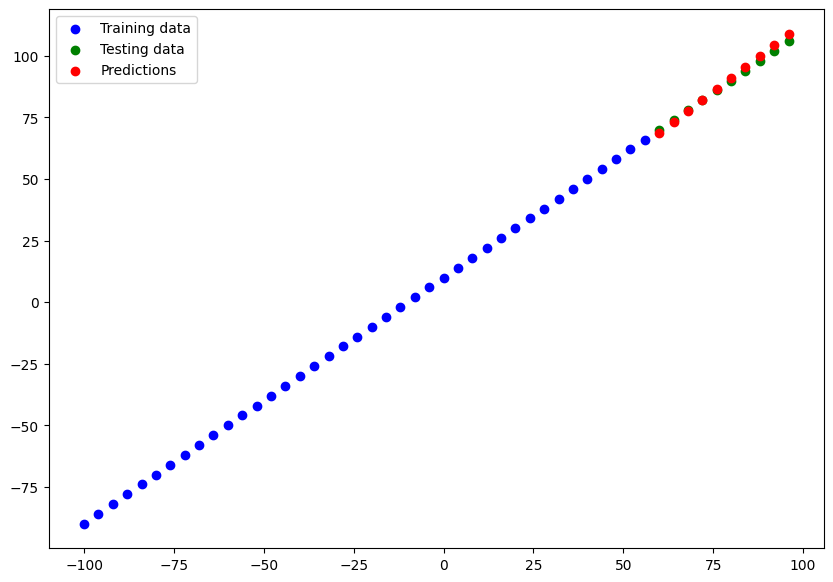

In [56]:
# Make and plot predictions for model_1
y_preds_1 = model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [57]:
def mae(y_test, y_pred):
  """
  Calculuates mean absolute error between y_test and y_preds.
  """
  return tf.keras.losses.mean_absolute_error(y_test, y_pred) # Use tf.keras.losses instead of tf.metrics

def mse(y_test, y_pred):
  """
  Calculates mean squared error between y_test and y_preds.
  """
  return tf.keras.losses.mean_squared_error(y_test, y_pred) # Use tf.keras.losses instead of tf.metrics

In [58]:
import tensorflow as tf

# Create metric objects
mae_object = tf.keras.metrics.MeanAbsoluteError()
mse_object = tf.keras.metrics.MeanSquaredError()

def mae(y_test, y_pred):
    """
    Calculates mean absolute error between y_test and y_pred.
    """
    mae_object.update_state(y_test, y_pred)
    return mae_object.result()

def mse(y_test, y_pred):
    """
    Calculates mean squared error between y_test and y_pred.
    """
    mse_object.update_state(y_test, y_pred)
    return mse_object.result()

# Calculate model_1 metrics
mae_1 = mae(y_test, y_preds_1.squeeze()).numpy()
mse_1 = mse(y_test, y_preds_1.squeeze()).numpy()
mae_1, mse_1

(1.3411484, 2.5921583)

#Build `model_2`

This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [59]:
import tensorflow as tf  # Import TensorFlow
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(42)

# Replicate model_1 and add an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1) # add a second layer
])

# Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100, verbose=1) # set verbose to 0 for less output

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 11.7066 - mae: 11.7066
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.4100 - mae: 20.4100 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7895 - mae: 9.7895 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.1601 - mae: 13.1601 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.3744 - mae: 16.3744 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.8369 - mae: 10.8369
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.0789 - mae: 12.0789 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.3231 - mae: 13.3231 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.1115 - mae: 16.1115 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3944 - mae: 9.3944
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.3874 - mae: 10.3874
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.4235 - mae: 11.4235 
Epoch 13/100
2/2 ━━━━━━━━━━━━━

# Fit a Tensorflow Model


---


## 1. model_2.fit(...): The fit() Method

This method trains the model (model_2) on the provided training data (X_train and y_train).

During training, the model iteratively adjusts its internal weights to minimize the loss function, improving its ability to make accurate predictions.

------
##2. tf.expand_dims(X_train, axis=-1): Expanding the Dimensions

The tf.expand_dims() function adds a new axis to the X_train data, effectively changing its shape.

This is often necessary when the model expects input data to have a specific shape.

For example, if your input data is a 1D array (like [1, 2, 3, ...]), tf.expand_dims(X_train, axis=-1) converts it into a 2D array with a shape that the model can process, such as [[1], [2], [3], ...].

##axis=-1:

The axis=-1 argument specifies that the new dimension should be added as the last axis.

This means if X_train originally had a shape of (n,) (where n is the number of samples), it will now have a shape of (n, 1).

----
-----
#Why It's Needed

If your model expects input data with a shape of (batch_size, 1) and your X_train is just (batch_size,), this function adjusts the shape accordingly.

-----
------
##3. y_train: Training Labels

y_train contains the true labels corresponding to the training data X_train.

These labels are what the model will attempt to predict during training.
During each iteration (epoch), the model makes predictions on X_train, compares them to y_train, and calculates the loss (error).

It then updates its weights to reduce this error in future predictions.

-----
##4. epochs=100: Number of Epochs

The epochs argument specifies the number of times the model will iterate over the entire training dataset.

In this case, the model will pass through the entire X_train and y_train dataset 100 times during training.

More epochs generally allow the model to learn better, but too many epochs can lead to overfitting, where the model learns the training data too well and performs poorly on new, unseen data.

-----
##5. verbose=1: Verbosity Level

The verbose argument controls the amount of information printed during training.

verbose=1 provides a detailed output for each epoch, including progress bars and performance metrics (like loss and accuracy).

This is useful for monitoring how the training process is progressing.

-----
##Other options include:

##verbose=0:

No output is printed during training (useful if you want to suppress output).

##verbose=2:

One line per epoch, showing just the final performance metrics.
Example Output When verbose=1:

When verbose=1, each epoch will produce an output similar to this:

---------
##Epoch 1/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0254 - mae: 0.0254

...

##Epoch 100/100

1/1 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0042

##Epoch X/Y

Indicates which epoch out of the total is currently running.

Time per step: Shows how long each step took (in milliseconds).

##Loss and Metrics: Displays the loss and any metrics being monitored (e.g., Mean Absolute Error, mae).

-------------
#Summary

This snippet trains model_2 on the X_train and y_train datasets for 100 epochs.

The tf.expand_dims() function ensures that the input data has the correct shape for the model, and verbose=1 provides detailed output about the training process, allowing you to monitor how the model is learning over time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


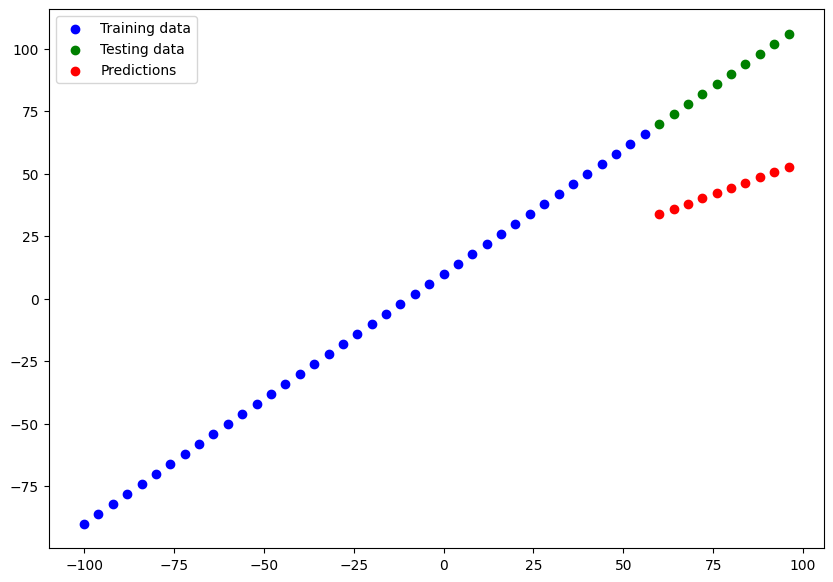

In [60]:
# Make and plot predictions for model_2
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

Woah, that's looking better already! And all it took was an extra layer.

In [61]:
import tensorflow as tf

# Create metric objects
mae_object = tf.keras.metrics.MeanAbsoluteError()
mse_object = tf.keras.metrics.MeanSquaredError()

def mae(y_test, y_pred):
    """
    Calculates mean absolute error between y_test and y_pred.
    """
    mae_object.update_state(y_test, y_pred)
    return mae_object.result()

def mse(y_test, y_pred):
    """
    Calculates mean squared error between y_test and y_pred.
    """
    mse_object.update_state(y_test, y_pred)
    return mse_object.result()

# Calculate model_2 metrics
mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
mae_2, mse_2

(44.698463, 2026.9834)

# Calculate the models MAE and the MSE


---


# 1. Importing TensorFlow

    import tensorflow as tf

Import TensorFlow, a popular machine learning library. All subsequent TensorFlow functions and objects will be accessed via the tf module.

------
# 2. Creating Metric Objects

    # Create metric objects
    mae_object = tf.keras.metrics.MeanAbsoluteError()
    mse_object = tf.keras.metrics.MeanSquaredError()

Create instances of TensorFlow's built-in metrics for calculating MAE and MSE.

mae_object: An instance of tf.keras.metrics.MeanAbsoluteError, which will be used to calculate the mean absolute error.

mse_object: An instance of tf.keras.metrics.MeanSquaredError, which will be used to calculate the mean squared error.

------
#3. Defining the mae Function

    def mae(y_test, y_pred):
       """
        Calculates mean absolute error between y_test and y_pred.
        """
       mae_object.update_state(y_test, y_pred)
       return mae_object.result()

This function calculates the Mean Absolute Error between the true values (y_test) and the predicted values (y_pred).

##update_state(y_test, y_pred)

Updates the internal state of mae_object with the new values. It essentially feeds the true and predicted values into the object.

##result()
After updating the state, this method returns the calculated MAE based on the data provided.

-------------
#4. Defining the mse Function

    def mse(y_test, y_pred):
       """
       Calculates mean squared error between y_test and y_pred.
       """
       mse_object.update_state(y_test, y_pred)
       return mse_object.result()

This function calculates the Mean Squared Error between the true values (y_test) and the predicted values (y_pred).

##update_state(y_test, y_pred)

Updates the internal state of mse_object with the new values.

##result()

Returns the calculated MSE.

-----
#5. Calculating Metrics for model_2

    # Calculate model_2 metrics
    mae_2 = mae(y_test, y_preds_2.squeeze()).numpy()
    mse_2 = mse(y_test, y_preds_2.squeeze()).numpy()
    mae_2, mse_2

Calculate the MAE and MSE for predictions made by model_2.

    y_test: The true values.
    y_preds_2.squeeze()
    
The predictions made by model_2, with the squeeze() function applied to remove single-dimensional entries from the shape (if y_preds_2 is shaped (n, 1), squeeze() converts it to (n,)).

##.numpy()

Converts the TensorFlow tensor returned by result() into a NumPy array, which is easier to handle in Python.

------
#6. Output
mae_2: Contains the Mean Absolute Error for model_2.

mse_2: Contains the Mean Squared Error for model_2.

mae_2, mse_2: Returns both values in a tuple.

-----------
#Summary
Metric Objects: mae_object and mse_object are used to calculate and keep track of the errors across multiple inputs.

Functions: The mae and mse functions update the metric objects with new data and return the calculated errors.

Application: The code calculates the MAE and MSE for a model's predictions (model_2) and converts the results to NumPy arrays for easy manipulation or display.

This approach is particularly useful when you want to calculate metrics over batches of data, as TensorFlow's metric objects are designed to accumulate results across multiple updates.

#Build `model_3'

For our 3rd model, we'll keep everything the same as `model_2` except this time we'll train for longer (500 epochs instead of 100).

This will give our model more of a chance to learn the patterns in the data.

In [62]:
# Set random seed
tf.random.set_seed(42)

# Replicate model_2
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['mae'])

# Fit the model (this time for 500 epochs, not 100)
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500, verbose=1) # set verbose to 0 for less output

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 42.8004 - mae: 42.8004 
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.0956 - mae: 21.0956 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6959 - mae: 8.6959
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.9762 - mae: 12.9762 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.2651 - mae: 15.2651
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.4621 - mae: 10.4621
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.5307 - mae: 11.5307
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.6381 - mae: 12.6381
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.4201 - mae: 14.4201
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5297 - mae: 11.5297 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.6095 - mae: 12.6095 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.3960 - mae: 14.3960 
Epoch 13/500
2/2 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


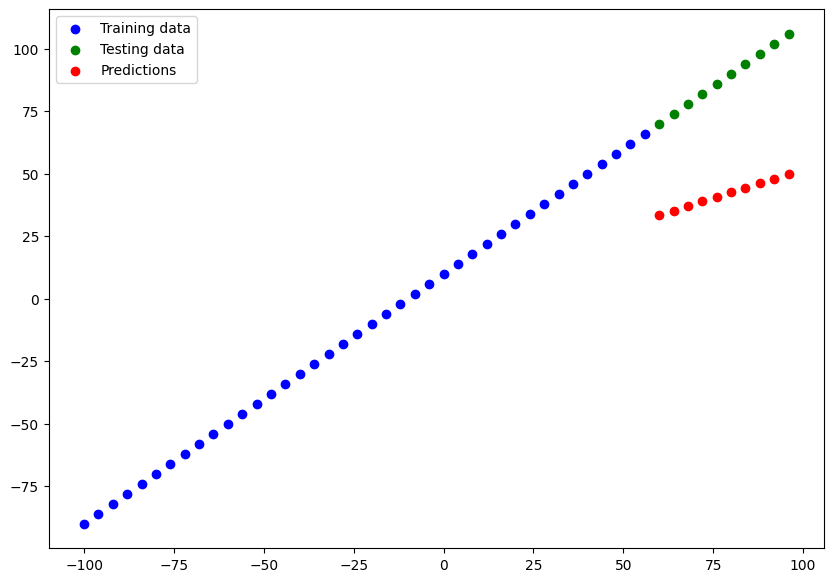

In [63]:
# Make and plot predictions for model_3
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

Strange, we trained for longer but our model performed worse?

As it turns out, our model might've trained too long and has thus resulted in worse results (we'll see ways to prevent training for too long later on).

In [64]:
# Calculate model_3 metrics
mae_3 = mae(y_test, y_preds_3.squeeze()).numpy()
mse_3 = mse(y_test, y_preds_3.squeeze()).numpy()
mae_3, mse_3

(45.50911, 2105.8022)

## Comparing results

Now we've got results for 3 similar but slightly different results, let's compare them.

In [65]:
model_results = [["model_1", mae_1, mse_1],
                 ["model_2", mae_2, mse_2],
                 ["model_3", mae_3, mae_3]]

In [66]:
import pandas as pd
all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
all_results

,model,mae,mse
0,model_1,1.341148,2.592158
1,model_2,44.698463,2026.983398
2,model_3,45.509109,45.509109


From our experiments, it looks like

*   List item
*   List item

# `model_3` performed the best.

And now, you might be thinking, "wow, comparing models is tedious..." and it definitely can be, we've only compared 3 models here.

But this is part of what machine learning modelling is about, trying many different combinations of models and seeing which performs best.

Each model you build is a small experiment.

> 🔑 **Note:** One of your main goals should be to minimize the time between your experiments.

The more experiments you do, the more things you'll figure out which don't work and in turn, get closer to figuring out what does work. Remember the machine learning practitioner's motto: "experiment, experiment, experiment".

Another thing you'll also find is what you thought may work (such as training a model for longer) may not always work and the exact opposite is also often the case.

## Tracking your experiments

One really good habit to get into is tracking your modelling experiments to see which perform better than others.

We've done a simple version of this above (keeping the results in different variables).

> 📖 **Resource:** But as you build more models, you'll want to look into using tools such as:
* [**TensorBoard**](https://tensorboard.dev/) - a component of the TensorFlow library to help track modelling experiments (we'll see this later).
* [**Weights & Biases**](https://www.wandb.com/) - a tool for tracking all kinds of machine learning experiments (the good news for Weights & Biases is it plugs into TensorBoard).

## Saving a model

Once you've trained a model and found one which performs to your liking, you'll probably want to save it for use elsewhere (like a web application or mobile device).

You can save a TensorFlow/Keras model using [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

There are two ways to save a model in TensorFlow:
1. The [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) (default).
2. The [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format).

The main difference between the two is the SavedModel is automatically able to save custom objects (such as special layers) without additional modifications when loading the model back in.

Which one should you use?

It depends on your situation but the SavedModel format will suffice most of the time.

Both methods use the same method call.

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
import tensorflow as tf # Or your preferred deep learning framework

# ... (Your model training code) ...
# Save the entire model
model.save('C:\\Users\\ppetr\\OneDrive\\50_Knowledge\\150_Udemy_Training\\50_Tensor_Flow\\Udemy_Tf\\BestModel.keras')
# Or, save just the weights (recommended)
model.save_weights('C:\\Users\\ppetr\\OneDrive\\50_Knowledge\\150_Udemy_Training\\50_Tensor_Flow\\Udemy_Tf\\BestModel_weights.weights.h5') # Changed file extension to .weights.h5

In [69]:
# Check it out - outputs a protobuf binary file (.pb) as well as other files
!ls best_model_SavedModel_format

ls: cannot access 'best_model_SavedModel_format': No such file or directory


Now let's save the model in the HDF5 format, we'll use the same method but with a different filename.

In [70]:
# Save a model using the HDF5 format
model_3.save("best_model_HDF5_format.h5") # note the addition of '.h5' on the end

In [71]:
# Check it out
!ls best_model_HDF5_format.h5

best_model_HDF5_format.h5


## Loading a model

We can load a saved model using the [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) method.

Loading a model for the different formats (SavedModel and HDF5) is the same (as long as the pathnames to the particular formats are correct).

In [79]:
# Load a model from the SavedModel format
loaded_saved_model = tf.keras.models.load_model("best_model_SavedModel_format")
loaded_saved_model.summary()

ValueError: File format not supported: filepath=best_model_SavedModel_format. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(best_model_SavedModel_format, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Now let's test it out.

In [80]:
# Compare model_2 with the SavedModel version (should return True)
model_2_preds = model_2.predict(X_test)
saved_model_preds = loaded_saved_model.predict(X_test)
mae(y_test, saved_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


NameError: name 'loaded_saved_model' is not defined

Loading in from the HDF5 is much the same.

In [76]:
# Load a model from the HDF5 format
loaded_h5_model = tf.keras.models.load_model("best_model_HDF5_format.h5")
loaded_h5_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 1)                   │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6 (28.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [77]:
# Compare model_2 with the loaded HDF5 version (should return True)
h5_model_preds = loaded_h5_model.predict(X_test)
mae(y_test, h5_model_preds.squeeze()).numpy() == mae(y_test, model_2_preds.squeeze()).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


False

## Downloading a model (from Google Colab)

Say you wanted to get your model from Google Colab to your local machine, you can do one of the following things:
* Right click on the file in the files pane and click 'download'.
* Use the code below.

In [75]:
# Download the model (or any file) from Google Colab
from google.colab import files
files.download("best_model_HDF5_format.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## A larger example

Alright, we've seen the fundamentals of building neural network regression models in TensorFlow.

Let's step it up a notch and build a model for a more feature rich dataset.

More specifically we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

> 🔑 **Note:** When learning machine learning paradigms, you'll often go through a series of foundational techniques and then practice them by working with open-source datasets and examples. Just as we're doing now, learn foundations, put them to work with different problems. Every time you work on something new, it's a good idea to search for something like "problem X example with Python/TensorFlow" where you substitute X for your problem.

In [4]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [6]:
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [7]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,True,False,False,False,True,False
2,28,33.000,3,4449.46200,False,True,True,False,False,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False,True,False,False


Now we'll split data into features (`X`) and labels (`y`).

In [8]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [9]:
# View features
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,True,False,False,True,False,False,False,True
1,18,33.770,1,False,True,True,False,False,False,True,False
2,28,33.000,3,False,True,True,False,False,False,True,False
3,33,22.705,0,False,True,True,False,False,True,False,False
4,32,28.880,0,False,True,True,False,False,True,False,False


And create training and test sets. We could do this manually, but to make it easier, we'll leverage the already available [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function available from Scikit-Learn.

In [10]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # set random state for reproducible splits

Now we can build and fit a model (we'll make it the same as `model_2`).

In [11]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Fit the model
insurance_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 10340.8105 - mae: 10340.8105
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7678.6699 - mae: 7678.6699 
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7566.4253 - mae: 7566.4253 
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7283.5581 - mae: 7283.5581 
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7234.1396 - mae: 7234.1396 
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7857.1968 - mae: 7857.1968 
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7660.9297 - mae: 7660.9297 
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7535.4624 - mae: 7535.4624 
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7361.2456 - mae: 7361.2456 
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7388.0566 - mae: 7388.0566 
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7330.9722 - mae: 7330.9722 
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Check the results of the insurance model
insurance_model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6792.5977 - mae: 6792.5977


[6563.498046875, 6563.498046875]

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

In [13]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 units
  tf.keras.layers.Dense(10), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works but SGD doesn't
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [14]:
# Evaluate our larger model
insurance_model_2.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4951.6606 - mae: 4951.6606


[4808.05615234375, 4808.05615234375]

Much better! Using a larger model and the Adam optimizer results in almost half the error as the previous model.

> 🔑 **Note:** For many problems, the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is a great starting choice. See Andrei Karpathy's "Adam is safe" point from [*A Recipe for Training Neural Networks*](http://karpathy.github.io/2019/04/25/recipe/) for more.

Let's check out the loss curves of our model, we should see a downward trend.

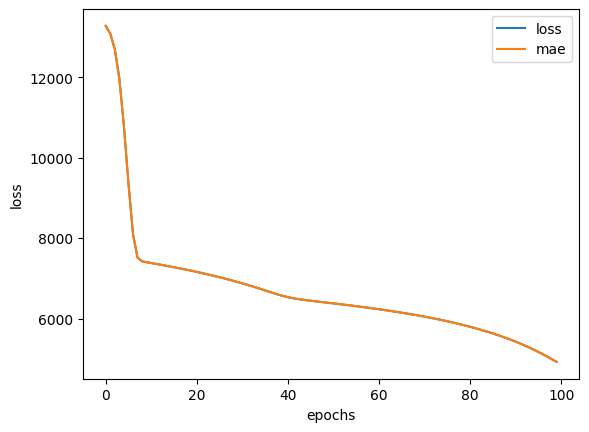

In [15]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer.

> 🤔 **Question:** How long should you train for?

> It depends on what problem you're working on. Sometimes training won't take very long, other times it'll take longer than you expect. A common method is to set your model training for a very long time (e.g. 1000's of epochs) but set it up with an [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) so it stops automatically when it stops improving. We'll see this in another module.

Let's train the same model as above for a little longer. We can do this but calling fit on it again.

In [16]:
# Try training for a little longer (100 more epochs)
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

How did the extra training go?

In [17]:
# Evaluate the model trained for 200 total epochs
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)
insurance_model_2_loss, insurance_model_2_mae

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3478.0615 - mae: 3478.0615 


(3412.4853515625, 3412.4853515625)

Boom! Training for an extra 100 epochs we see about a 10% decrease in error.

How does the visual look?

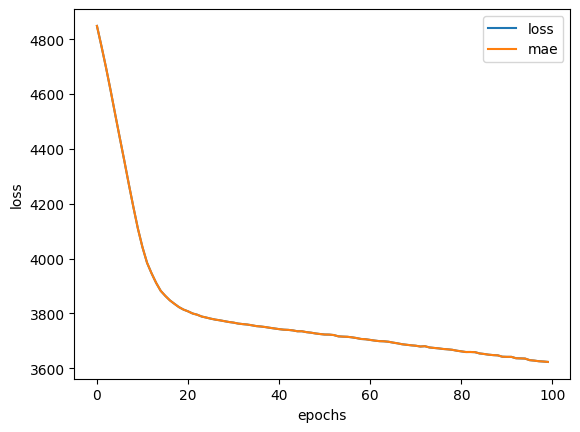

In [18]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable

## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare your data for use with neural networks).

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minimum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by subtracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks you'll tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, I'd recommend reading the following resources:
* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

We've already turned our data into numbers using `get_dummies()`, let's see how we'd normalize it as well.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [20]:
# Check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [21]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split  # Importing train_test_split

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

# Data Preprocessing -Regularization & One Hot Encoding


---


# 1. Import Necessary Libraries

    from sklearn.compose import make_column_transformer
    from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
    from sklearn.model_selection import train_test_split

##make_column_transformer

Allows you to apply different preprocessing steps to different columns in your dataset.

##MinMaxScaler

Scales numerical data so that it falls within a specific range (typically 0 to 1).

##OneHotEncoder

Converts categorical data into a binary (0 or 1) format that can be used by machine learning algorithms.

##train_test_split

Splits your data into training and testing sets to evaluate your model's performance.

--------------
#2. Create a Column Transformer

    ct = make_column_transformer(
       (MinMaxScaler(), ["age", "bmi", "children"]), # Scale numerical columns

      (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"]) # Encode categorical columns
     )

##MinMaxScaler()

Applied to the age, bmi, and children columns, scaling these features to a range between 0 and 1.

##OneHotEncoder(handle_unknown="ignore")

Applied to sex, smoker, and region columns.

It converts these categorical variables into a series of binary variables (one-hot encoding).

##The handle_unknown="ignore"

parameter ensures that any categories in the test set that weren't seen in the training set are ignored rather than causing an error.

##The transformations using MinMaxScaler and OneHotEncoder are not performed "in place" in the DataFrame. Here's why:

----------------------
---------------
###MinMaxScaler:

When you apply MinMaxScaler to specific columns of a DataFrame, it transforms the values of those columns and returns the transformed data as a new array.

If you want the transformed values to be reflected in the original DataFrame, you need to explicitly assign the transformed data back to the respective columns in the DataFrame. This is not done "in place" automatically; you need to perform this step manually.

###OneHotEncoder:
OneHotEncoder converts categorical columns into a set of binary (one-hot) encoded columns. It typically returns a sparse matrix or a NumPy array with the transformed data.

One-hot encoding will not modify the DataFrame "in place."

##You would need to manually integrate the one-hot encoded columns back into the original DataFrame if that's your intention.

------
#Practical Example:

    import pandas as pd
  from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Sample DataFrame
    df = pd.DataFrame({
      'age': [25, 32, 47, 51],
      'bmi': [22.5, 24.7, 30.1, 27.8],
      'children': [0, 1, 3, 2],
      'sex': ['male', 'female', 'male', 'female'],
      'smoker': ['yes', 'no', 'yes', 'no'],
      'region': ['northwest', 'southeast', 'southwest', 'northeast']
    })

# Apply MinMaxScaler to 'age', 'bmi', 'children'
scaler = MinMaxScaler()
df[['age', 'bmi', 'children']] = scaler.fit_transform(df[['age', 'bmi', 'children']])

# Apply OneHotEncoder to 'sex', 'smoker', 'region'
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(df[['sex', 'smoker', 'region']])

# Convert encoded columns back to a DataFrame and concatenate with original df
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['sex', 'smoker', 'region']))

    df = pd.concat([df.drop(['sex', 'smoker', 'region'], axis=1), encoded_df], axis=1)

###print(df)


-----
##Explanation:
MinMaxScaler: The values in the age, bmi, and children columns are scaled and updated in the original DataFrame because they were explicitly reassigned to the same columns.

OneHotEncoder: The original categorical columns (sex, smoker, region) are replaced with their one-hot encoded versions, which were manually integrated back into the DataFrame after transformation.

So, to conclude, the transformations are not done "in place" by default. They require manual steps to update the DataFrame accordingly.

#BUT  the make_column_transformer, in the above snippet, Works as follows:
MinMaxScaler is applied to the columns ["age", "bmi", "children"]. The scaler normalizes these columns, resulting in scaled numeric data.

OneHotEncoder is applied to the columns ["sex", "smoker", "region"]. This encoder transforms the categorical data into one-hot encoded columns.

#What Happens During Transformation:
##The transform() method of the ColumnTransformer (ct) combines the results of these transformations into a single array (or sparse matrix).

This array contains all the transformed data, including both the scaled numeric columns and the one-hot encoded categorical columns.

##No manual concatenation is necessary because the ColumnTransformer handles all of the transformations and merges the results into a single output array.

#Automatic Handling:

ColumnTransformer handles both scaling and encoding and returns a combined array without needing additional steps to concatenate results.

Output Format: The output (X_train_normal and X_test_normal) is a NumPy array (or sparse matrix) rather than a DataFrame, so it already contains all the transformed features together.

No Need for Concatenation: Since the output includes all transformed columns together, manual concatenation with the original DataFrame is unnecessary.

If you need to work with the transformed data as a DataFrame instead of a NumPy array, you can convert it back to a DataFrame, ensuring you have the correct column names (especially after one-hot encoding).

--------
---------------
##3. Define Features (X) and Target (y)

    X = insurance.drop("charges", axis=1)
    y = insurance["charges"]

X: The features are created by dropping the charges column, as it is the target variable.

y: The target variable, which the model will try to predict, is set to the charges column.

------
#4. Split the Data into Training and Test Sets

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_test_split: This function splits X and y into training and testing sets.

test_size=0.2: 20% of the data is set aside as the test set.

random_state=42: Ensures that the split is reproducible.

-------------------------------
#5. Fit the Column Transformer on Training Data

    ct.fit(X_train)

ct.fit(X_train): The column transformer is fitted only on the training data.

This step calculates the necessary parameters (like the min and max for scaling) using the training data.

It's essential to fit on the training data to avoid data leakage, which could bias the model evaluation.

---------------
#6. Transform the Data

    X_train_normal = ct.transform(X_train)
    X_test_normal = ct.transform(X_test)

ct.transform(X_train): The fitted column transformer is applied to the training data to produce normalized and encoded data ready for model training.

ct.transform(X_test): The same transformation is applied to the test data. The test set is not used for fitting to avoid data leakage.

--------------------------
#Summary

This code snippet prepares data for a machine learning model by scaling numerical features and encoding categorical features.

The data is then split into training and testing sets to evaluate the model's performance fairly.

Key Concept: The use of make_column_transformer ensures that different preprocessing steps are applied correctly to different types of features, and fitting on the training data only is crucial to avoid data leakage.

Now we've normalized it and one-hot encoding it, what does our data look like now?

In [22]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

,0
age,19
sex,female
bmi,27.9
children,0
smoker,yes
region,southwest


In [23]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

How about the shapes?

In [24]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

We'll use the same model as `insurance_model_2`.

In [25]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
insurance_model_3.fit(X_train_normal, y_train, epochs=200, verbose=0)

Let's evaluate the model on normalized test set.

In [26]:
# Evaulate 3rd model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3214.2634 - mae: 3214.2634


And finally, let's compare the results from `insurance_model_2` (trained on non-normalized data) and `insurance_model_3` (trained on normalized data).

In [27]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

(3412.4853515625, 3161.107177734375)

From this we can see normalizing the data results in 10% less error using the same model than not normalizing the data.

This is **one of the main benefits of normalization: faster convergence time** (a fancy way of saying, your model gets to better results faster).

`insurance_model_2` may have eventually achieved the same results as `insurance_model_3` if we left it training for longer.

Also, the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

But since our main goal as neural network practitioners is to decrease the time between experiments, anything that helps us get better results sooner is a plus.

## 🛠 Exercises

We've a covered a whole lot pretty quickly.

So now it's time to have a **play around** with a few things and start to build up your intuition.

I emphasise the words play around because that's very important. Try a few things out, run the code and see what happens.

1. Create your own regression dataset (or make the one we created in "Create data to view and fit" bigger) and build fit a model to it.
2. Try building a neural network with 4 Dense layers and fitting it to your own regression dataset, how does it perform?
3. Try and improve the results we got on the insurance dataset, some things you might want to try include:
  * Building a larger model (how does one with 4 dense layers go?).
  * Increasing the number of units in each layer.
  * Lookup the documentation of [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and find out what the first parameter is, what happens if you increase it by 10x?
  * What happens if you train for longer (say 300 epochs instead of 200)?
4. Import the [Boston pricing dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) from TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and model it.


## 📖 Extra curriculum

If you're looking for extra materials relating to this notebook, I'd check out the following:

* [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - gives a great overview of what's happening behind all of the code we're running.
* Reading: 1-hour of [Chapter 1 of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielson - a great in-depth and hands-on example of the intuition behind neural networks.

To practice your regression modelling with TensorFlow, I'd also encourage you to look through [Lion Bridge's collection of datasets](https://lionbridge.ai/datasets/) or [Kaggle's datasets](https://www.kaggle.com/data), find a regression dataset which sparks your interest and try to model.